In [32]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))
from synth_dim_model import *

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

In [33]:
N = 2
M = 5

n_excited_states = 8
cmap = plt.get_cmap("gist_rainbow")
colors = [cmap(i / (n_excited_states + 1)) for i in range(n_excited_states + 1)]

min_J_V_ratio = -2.5
max_J_V_ratio = 2.5
max_mu_value = 2

resolution = 1000

mu_values = np.linspace(0, max_mu_value, resolution)
J_V_ratio_values = np.linspace(min_J_V_ratio, max_J_V_ratio, resolution)

mu_grid, J_V_ratio_grid = np.meshgrid(mu_values, J_V_ratio_values)

one_over_energy_gap_df = pd.read_csv('one_over_energy_gap.csv', index_col='J/V_ratio')
one_over_energy_gap_grid = one_over_energy_gap_df.to_numpy()

In [34]:
def interpolate_parameters(param_initial, param_final, t_total, dt=1, method="linear"):
    times = np.linspace(0, t_total, int(t_total/dt))
    params = []

    for t in times:
        s = t / t_total

        if method == "linear":
            instantaneous_param = (1 - s) * param_initial + s * param_final\
        
        elif method == "sinusoidal":
            instantaneous_param = (1 - np.sin(np.pi/2 * s)) * param_initial + np.sin(np.pi/2 * s) * param_final
        
        elif method == "smoothstep":
            s_smooth = s**2 * (3 - 2 * s)
            instantaneous_param = (1 - s_smooth) * param_initial + s_smooth * param_final

        else:
            raise ValueError(f"Unknown interpolation method: {method}")

        params.append(instantaneous_param)

    params = np.array(params)
    return params


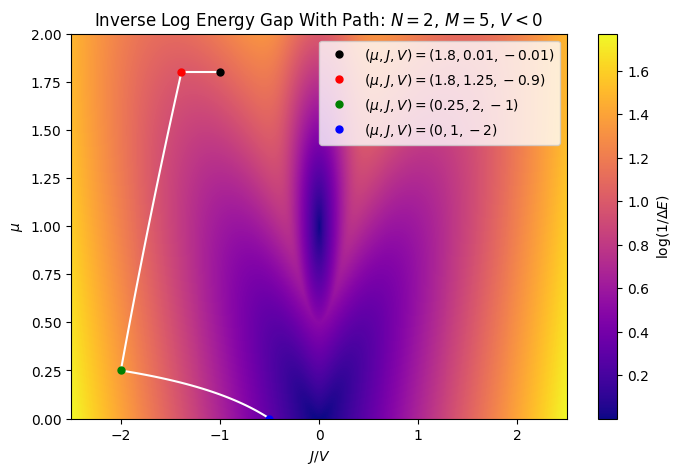

In [55]:
# initial point

init_mu = 1.8
init_J = 0.01
init_V = -0.01

# first point

mu1 = 1.8
J1 = 1.25
V1 = -0.9

# second point

mu2 = 0.25
J2 = 2
V2 = -1

# final point

final_mu = 0
final_J = 1
final_V = -2 

t_total = 100

plt.figure(figsize = (8,5))
plt.pcolormesh(J_V_ratio_grid, mu_grid, 1/one_over_energy_gap_grid, shading='auto', cmap='plasma')


mu_array_first_step = interpolate_parameters(init_mu, mu1, t_total/3, method = "linear") 
J_array_first_step = interpolate_parameters(init_J, J1, t_total/3, method = "linear") 
V_array_first_step = interpolate_parameters(init_V, V1, t_total/3, method = "linear") 

J_V_ratio_array_first_step = J_array_first_step/V_array_first_step
plt.plot(J_V_ratio_array_first_step, mu_array_first_step, color="w", linestyle='-', markersize=1)

mu_array_second_step = interpolate_parameters(mu1, mu2, t_total/3, method = "linear") 
J_array_second_step = interpolate_parameters(J1, J2, t_total/3, method = "linear") 
V_array_second_step = interpolate_parameters(V1, V2, t_total/3, method = "linear") 

J_V_ratio_array_second_step = J_array_second_step/V_array_second_step
plt.plot(J_V_ratio_array_second_step, mu_array_second_step, color="w", linestyle='-', markersize=1)

mu_array_third_step = interpolate_parameters(mu2, final_mu, t_total/3, method = "linear") 
J_array_third_step = interpolate_parameters(J2, final_J, t_total/3, method = "linear") 
V_array_third_step = interpolate_parameters(V2, final_V, t_total/3, method = "linear") 

J_V_ratio_array_third_step = J_array_third_step/V_array_third_step
plt.plot(J_V_ratio_array_third_step, mu_array_third_step, color="w", linestyle='-', markersize=1)


plt.plot(init_J/init_V, init_mu, 'ko', markersize=5, label = f'$(\mu, J, V) = ({init_mu}, {init_J}, {init_V})$')
plt.plot(J_V_ratio_array_first_step[-1], mu_array_first_step[-1] , 'ro', markersize=5, label = f'$(\mu, J, V) = ({mu1}, {J1}, {V1})$')
plt.plot(J_V_ratio_array_second_step[-1], mu_array_second_step[-1] , 'go', markersize=5, label = f'$(\mu, J, V) = ({mu2}, {J2}, {V2})$')
plt.plot(final_J/final_V, final_mu, 'bo', markersize=5, label = f'$(\mu, J, V) = ({final_mu}, {final_J}, {final_V})$')

plt.xlabel("$J/V$")
plt.ylabel("$\mu$")
plt.title(f"Inverse Log Energy Gap With Path: $N=${N}, $M=${M}, $V<0$")
plt.colorbar(label="$\log(1/\Delta E)$")
plt.legend()


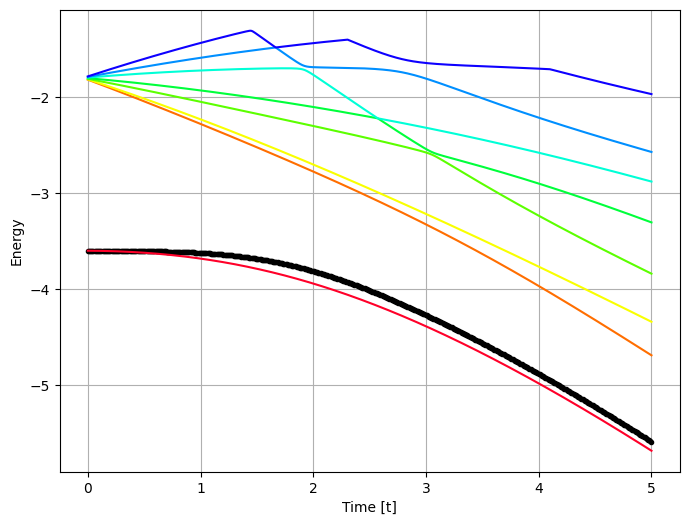

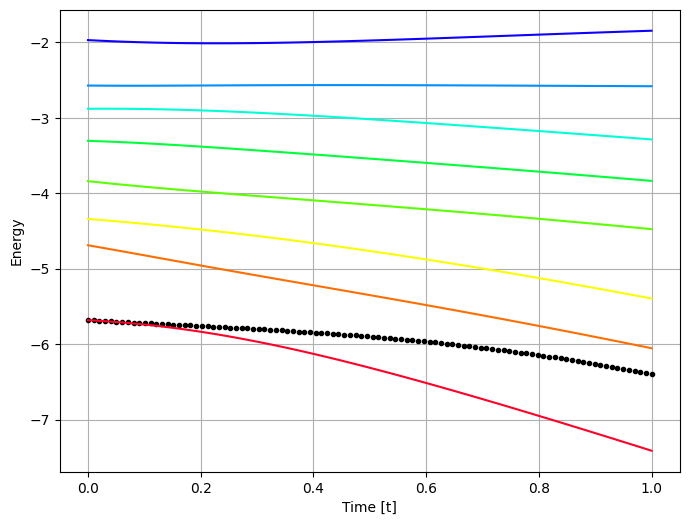

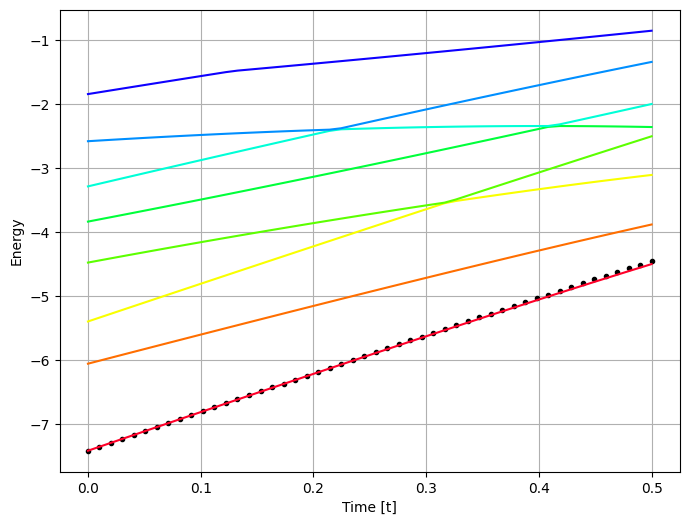

In [56]:
T1 = 5

# path 1

adiabatic_energies, adiabatic_diff, adiabatic_wavefunctions, overlaps_all_states, true_energies, energy_gaps, times = \
    calculate_adiabatic_properties(N, M, init_mu, init_J, init_V, mu = mu1, J = J1 , V = V1, t_total = T1, dt = 0.01)

fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(times, adiabatic_energies, color="black", marker=".", linestyle="", label="$\Psi^\dagger(t) H \Psi(t)$")

for i in range(n_excited_states):
    ax.plot(times, true_energies[:, i], color=colors[i], label=f"$E_{i}$")

#ax.set_title(f"Energies: $N=${N}, $M=${M}, $J = ${J1}, $V = ${V1}, $T=${T1}, $dt=0.01$")
ax.set_xlabel("Time [t]")
ax.set_ylabel("Energy")
#ax.legend(loc="lower center", ncols = (n_excited_states+1)//2)
ax.grid(True)

# path 2

T2 = 1

adiabatic_energies, adiabatic_diff, adiabatic_wavefunctions, overlaps_all_states, true_energies, energy_gaps, times = \
    calculate_adiabatic_properties(N, M, init_mu = mu1, init_J = J1, init_V = V1, mu = mu2, J = J2 , V = V2, t_total = T2, dt = 0.01)

fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(times, adiabatic_energies, color="black", marker=".", linestyle="", label="$\Psi^\dagger(t) H \Psi(t)$")

for i in range(n_excited_states):
    ax.plot(times, true_energies[:, i], color=colors[i], label=f"$E_{i}$")

#ax.set_title(f"Energies: $N=${N}, $M=${M}, $J = ${J1}, $V = ${V1}, $T=${T2}, $dt=0.01$")
ax.set_xlabel("Time [t]")
ax.set_ylabel("Energy")
#ax.legend(loc="lower center", ncols = (n_excited_states+1)//2)
ax.grid(True)

# path 3

T3 = 0.5

adiabatic_energies, adiabatic_diff, adiabatic_wavefunctions, overlaps_all_states, true_energies, energy_gaps, times = \
    calculate_adiabatic_properties(N, M, init_mu = mu2, init_J = J2, init_V = V2, mu = final_mu, J = final_J, V = final_V, t_total = T3, dt = 0.01)

fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(times, adiabatic_energies, color="black", marker=".", linestyle="", label="$\Psi^\dagger(t) H \Psi(t)$")

for i in range(n_excited_states):
    ax.plot(times, true_energies[:, i], color=colors[i], label=f"$E_{i}$")

#ax.set_title(f"Energies: $N=${N}, $M=${M}, $J = ${J1}, $V = ${V1}, $T=${T3}, $dt=0.01$")
ax.set_xlabel("Time [t]")
ax.set_ylabel("Energy")
#ax.legend(loc="lower center", ncols = (n_excited_states+1)//2)
ax.grid(True)